Trying to use guide https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

In [26]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

## from REFIT tutorial
from lxml import objectify
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [27]:
path=r'dataset/REFIT_BUILDING_SURVEY.xml'
tree = objectify.parse(path)
root = tree.getroot()
NS={'a':'http://www.refitsmarthomes.org'}

path=r'dataset/REFIT_TIME_SERIES_VALUES.csv'

try:
    csv
except:
    csv=pd.read_csv(path, index_col=0, parse_dates=[1])
    
    
    
## Global parameters
building_num = 1

In [139]:
## Get climate data
elements=root.xpath('./a:Stock/a:Climate/a:Sensor/a:TimeSeriesVariable', namespaces=NS)
data_clim = {}
time_clim = []
agg = {}
period = 'H'

for e in elements:
    id = e.get('id')
    v = csv.loc[id]
    sensor_name = e.get('variableType').replace(' ', '_')
    if len(time_clim) < 1:
        time_clim = v['dateTime'].tolist() 
    if sensor_name == 'Total_rainfall':
        tmp = np.sum
    else:
        tmp = np.mean
    agg[sensor_name] = tmp
    data_clim[sensor_name] = v['data'].tolist()
climdf = pd.DataFrame(data_clim, index=time_clim).resample(period).agg(agg)
##clean climdf (only when not resamplet for Day 'D')
#climdf = climdf.iloc[1::2] ## Some timeSteps are not in gas_meter indexes (15 mins and 45 mins values, 00 and 30 mins are in)

    
## Get gas meter data
appliance    = 1 #Number of gas meter
tsv = root.xpath('./a:Stock/a:Building[%d]/a:Meter[%d]/a:Sensor/a:TimeSeriesVariable' % (building_num, appliance), namespaces=NS)
id = tsv[0].get('id')
gasdf = csv.loc[id]
data_gas = {'gas': gasdf['data'].tolist()}
time_gas = gasdf['dateTime'].tolist()
gasdf = pd.DataFrame(data_gas, index=time_gas).resample(period).sum()
agg['gas'] = np.sum

## Merge two DataFrames gas meter and weather
df = pd.concat([climdf, gasdf], axis=1)
## clean rows
df = df[np.isfinite(df['Air_temperature'])]   # We don't need data where no weather forecast
lastind = time_gas[-1]
df = df[:lastind]                             # We don't need data where no meter values


## NaN rows detection
j = len(df.columns) - 1 # last column is 'gas'
df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
df.isnull().sum()

Air_temperature                        0
Relative_humidity                      0
Wind_speed                             0
Wind_direction_D1                      0
Wind_direction_SD1                     0
Average_horizontal_solar_irradiance    0
Total_horizontal_solar_irradiation     0
NR_Wm2_Avg                             0
CNR_Wm2_Avg                            0
Total_rainfall                         0
Average_barometric_pressure            0
gas                                    0
dtype: int64

In [140]:
df['Wind_speed'].argmax()

C:\Users\Ford\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


Timestamp('2014-08-25 22:00:00', freq='H')

In [141]:
df.describe()

,Air_temperature,Relative_humidity,Wind_speed,Wind_direction_D1,Wind_direction_SD1,Average_horizontal_solar_irradiance,Total_horizontal_solar_irradiation,NR_Wm2_Avg,CNR_Wm2_Avg,Total_rainfall,Average_barometric_pressure,gas
count,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.00000,13167.000000,13167.000000,13167.000000
mean,9.862965,80.878419,1.688931,201.652367,35.285495,0.091155,0.821077,20.826535,20.84122,0.083041,1005.985216,0.152679
std,5.439630,12.376633,10.423738,78.820119,15.357090,0.159151,1.431899,105.405726,105.65288,0.390869,12.655515,0.208213
min,-3.576750,29.912500,0.127500,5.234750,9.733500,0.000000,0.000754,-180.465000,-188.00000,0.000000,960.000000,0.000000
25%,5.762500,74.717500,0.859750,136.962500,23.978750,0.000000,0.001492,-42.651250,-42.69125,0.000000,998.000000,0.000000
50%,9.132500,83.950000,1.380000,224.650000,31.240000,0.001750,0.015682,-14.747750,-14.78250,0.000000,1007.000000,0.000000
75%,13.511250,90.300000,2.020250,268.850000,42.427500,0.108750,0.979007,30.880000,30.88000,0.000000,1015.000000,0.340000
max,30.897500,97.800000,880.775000,353.750000,98.275000,0.856000,7.703240,551.475000,709.19750,16.200000,1034.000000,1.270000


In [142]:
df.head()

,Air_temperature,Relative_humidity,Wind_speed,Wind_direction_D1,Wind_direction_SD1,Average_horizontal_solar_irradiance,Total_horizontal_solar_irradiation,NR_Wm2_Avg,CNR_Wm2_Avg,Total_rainfall,Average_barometric_pressure,gas
2013-11-04 09:00:00,5.777333,78.066667,1.90200,286.466667,21.726667,0.066667,0.458153,-64.273333,-64.273333,0.0,984.333333,0.54
2013-11-04 10:00:00,7.186000,73.962500,2.13525,284.150000,23.452500,0.252250,2.270645,50.895000,50.897500,0.0,985.250000,0.04
2013-11-04 11:00:00,8.450000,72.830000,2.33425,283.325000,27.000000,0.321250,2.891341,125.150000,125.150000,0.0,986.000000,0.00
2013-11-04 12:00:00,9.522500,65.207500,3.07175,286.350000,24.722500,0.325500,2.928205,165.600000,165.725000,0.0,986.000000,0.00
2013-11-04 13:00:00,9.852500,65.977500,3.54825,290.075000,23.997500,0.279750,2.520264,119.350000,119.750000,0.0,986.250000,0.00


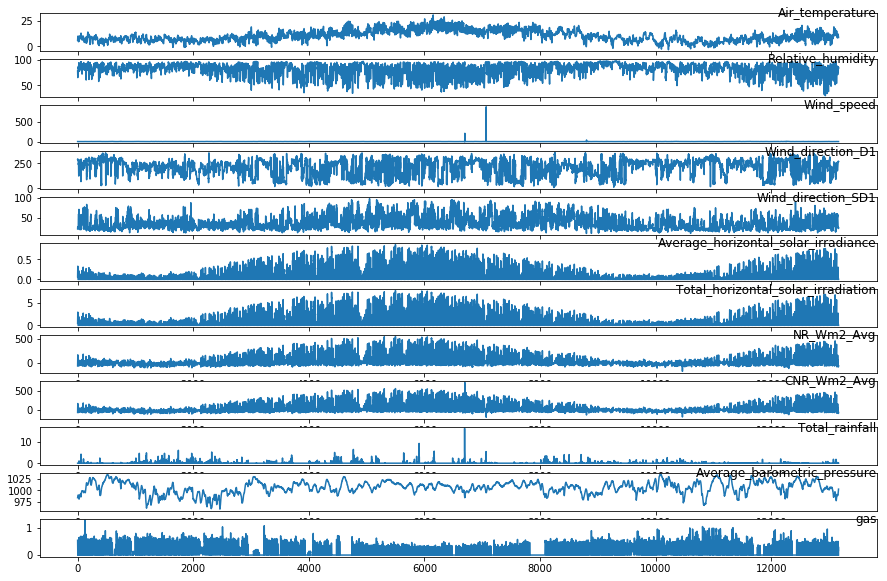

In [143]:
cols = list(range(len(df.columns)))
i = 1
groups=cols
values = df.values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
    plt.subplot(len(cols), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.75, loc='right')
    i += 1
plt.show()

C:\Users\Ford\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  after removing the cwd from sys.path.
C:\Users\Ford\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  import sys
C:\Users\Ford\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  if __name__ == '__main__':


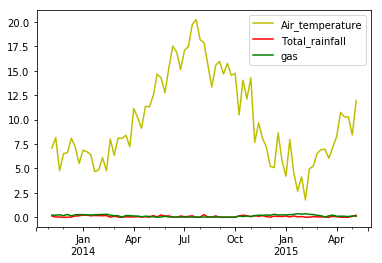

In [144]:
period = 'W' ## M, Q, W, A == Year

## resampling over week and computing mean
df.Air_temperature.resample(period).plot(color='y', legend=True)
# df.Average_barometric_pressure.resample(period).mean().plot(color='r', legend=True)
# df.Relative_humidity.resample(period).mean().plot(color='b', legend=True)
df.Total_rainfall.resample(period).plot(color='r', legend=True)
# df.Wind_speed.resample(period).plot(color='b', legend=True)
df.gas.resample(period).plot(color='g', legend=True)
plt.show()

0: Air_temperature
1: Relative_humidity
2: Wind_speed
3: Wind_direction_D1
4: Wind_direction_SD1
5: Average_horizontal_solar_irradiance
6: Total_horizontal_solar_irradiation
7: NR_Wm2_Avg
8: CNR_Wm2_Avg
9: Total_rainfall
10: Average_barometric_pressure
11: gas


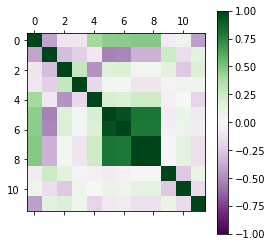

In [216]:
def pltCor(df):
    print('\n'.join(['%d: %s' % (i, j) for i, j in enumerate(df.columns.tolist())]))
    # Correlations among columns
    plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.colorbar()
    plt.show()

pltCor(df)

0: Air_temperature
1: Relative_humidity
2: Wind_speed
3: Wind_direction_D1
4: Wind_direction_SD1
5: Average_horizontal_solar_irradiance
6: Total_horizontal_solar_irradiation
7: NR_Wm2_Avg
8: CNR_Wm2_Avg
9: Total_rainfall
10: Average_barometric_pressure
11: gas


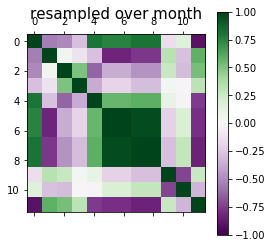

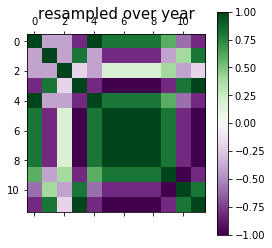

In [146]:
# Correlations of mean of features resampled over months

print('\n'.join(['%d: %s' % (i, j) for i, j in enumerate(df.columns.tolist())]))

plt.matshow(df.resample('W').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('6M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

## Start to prepare data and build model

In [219]:
df_resample = df.resample('D').agg(agg)
df_resample.shape

(549, 12)

In [220]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

0: var1(t-1)
1: var2(t-1)
2: var3(t-1)
3: var4(t-1)
4: var5(t-1)
5: var6(t-1)
6: var7(t-1)
7: var8(t-1)
8: var9(t-1)
9: var10(t-1)
10: var11(t-1)
11: var12(t-1)
12: var12(t)


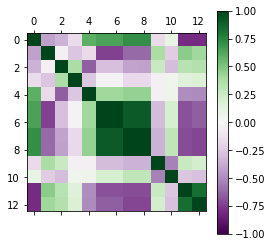

   var1(t-1)  var2(t-1)  var3(t-1)   var4(t-1)  var5(t-1)  var6(t-1)  \
1   7.226389  77.830111   1.935867  272.266111  26.024278   0.095828   
2   7.292073  85.644896   1.604083  227.374583  35.078958   0.028760   
3   9.435240  88.898021   1.229490  225.651146  36.265937   0.025417   
4   8.161823  85.208021   1.293573  244.714583  36.519896   0.044812   
5   6.822312  90.227396   1.068292  234.537500  46.746146   0.031427   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.853408  -7.639889  -7.604389         0.0  987.972222        1.27   
2   0.259557 -19.631583 -19.635323         4.2  985.458333        7.43   
3   0.229567  -3.700417  -3.703594        13.0  989.937500        4.66   
4   0.404218 -29.879510 -29.879615         0.0  997.541667        4.88   
5   0.283229 -23.128604 -23.128917         4.6  996.906250        5.68   

   var12(t)  
1      7.43  
2      4.66  
3      4.88  
4      5.68  
5      7.20   

Shape is:  (548, 13)


In [221]:
values = df_resample.values 

# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)


# drop columns we don't want to predict
reframed.drop(reframed.columns[list(range(12,23))], axis=1, inplace=True)
pltCor(reframed)
print(reframed.head(), '\n')
print('Shape is: ', reframed.shape)

In [222]:
## Scale data to (0..1) values range
values = reframed.values

X,Y = values[:, :-1], values[:, -1]
scalerX = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
scalerY = MinMaxScaler(feature_range=(0, 1))
Y = scalerY.fit_transform(Y.reshape(-1, 1))


## Split into train and test sets
n_train_time = int(reframed.shape[0] * 0.67)
train_X, train_y = X[:n_train_time, :], Y[:n_train_time, :]
test_X, test_y   = X[n_train_time:, :], Y[n_train_time:, :]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(367, 1, 12) (367, 1) (181, 1, 12) (181, 1)


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=7, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
# invert scaling for forecast
inv_yhat = scalerY.inverse_transform(yhat)
# invert scaling for actual
inv_y = scalerY.inverse_transform(test_y)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Train on 367 samples, validate on 181 samples
Epoch 1/20


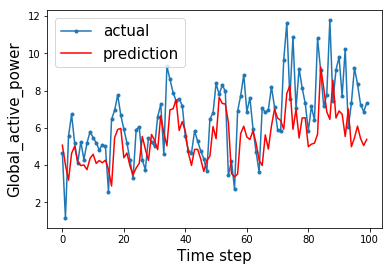

In [227]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(100)]
plt.plot(aa, inv_y[:100], marker='.', label="actual")
plt.plot(aa, inv_yhat[:100], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


## TODO: запихнуть время в датасет
